In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.io as sio
import torch
from torch import nn, optim
from torch.utils import data
from pyriemann.utils.mean import mean_covariance
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=5)
        self.conv2_bn = nn.BatchNorm2d(12)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(18252, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), (3, 3)))
        x = F.relu(F.max_pool2d(self.conv2_bn(self.conv2(x)), (3, 3)))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


def get_data(method):
    '''
    Navigates through file tree and extracts FCs with optional reconstruction
    '''
    fname = '../data/100_unrelated.csv'
    yeo = True
    if yeo:
        yeo_order = list(sio.loadmat("../data/yeo_RS7_N374.mat",
                                     squeeze_me=True,
                                     struct_as_record=False)['yeoOrder'] - 1)
    subjectids = np.loadtxt(fname, dtype=np.int)
    nSubj = len(subjectids)
    tasks = ['rfMRI_REST1_LR', 'rfMRI_REST1_RL', 'rfMRI_REST2_LR',
             'rfMRI_REST2_RL', 'tfMRI_EMOTION_LR', 'tfMRI_EMOTION_RL',
             'tfMRI_GAMBLING_LR', 'tfMRI_GAMBLING_RL', 'tfMRI_LANGUAGE_LR',
             'tfMRI_LANGUAGE_RL', 'tfMRI_MOTOR_LR', 'tfMRI_MOTOR_RL',
             'tfMRI_RELATIONAL_LR', 'tfMRI_RELATIONAL_RL', 'tfMRI_SOCIAL_LR',
             'tfMRI_SOCIAL_RL', 'tfMRI_WM_LR', 'tfMRI_WM_RL']

    M = {}
    for task in tasks:
        masterFC_dir = '../data/results_SIFT2'
        restingstatename = 'fMRI/' + task + '/FC/FC_glasser_subc_GS_bp_z.mat'
        task_matrices = []
        for subject in subjectids:
            filename = masterFC_dir + '/' + \
                str(subject) + '/' + restingstatename
            mat = sio.loadmat(filename, squeeze_me=True,
                              struct_as_record=False)
            A_orig = mat['FC']
            if yeo:
                A_orig = A_orig[np.ix_(yeo_order, yeo_order)]
            np.fill_diagonal(A_orig, 1)
            task_matrices.append(A_orig)
        M[task] = np.array(task_matrices)
    test = np.concatenate((M['rfMRI_REST1_LR'], M['tfMRI_EMOTION_LR'],
                           M['tfMRI_GAMBLING_LR'], M['tfMRI_LANGUAGE_LR'],
                           M['tfMRI_MOTOR_LR'], M['tfMRI_RELATIONAL_LR'],
                           M['tfMRI_SOCIAL_LR'], M['tfMRI_WM_LR']))
    retest = np.concatenate((M['rfMRI_REST1_RL'], M['tfMRI_EMOTION_RL'],
                             M['tfMRI_GAMBLING_RL'], M['tfMRI_LANGUAGE_RL'],
                             M['tfMRI_MOTOR_RL'], M['tfMRI_RELATIONAL_RL'],
                             M['tfMRI_SOCIAL_RL'], M['tfMRI_WM_RL']))
    del M
    all_FC = np.float32(np.concatenate((test, retest)))
    del test, retest
    tangent_FC = tangential(all_FC, method)
    return tangent_FC, nSubj


def q1invm(q1, eig_thresh=0):
    U, S, V = scipy.linalg.svd(q1)
    s = np.diag(S)
    s[s < eig_thresh] = eig_thresh
    S = np.diag(s ** (-1 / 2))
    Q1_inv_sqrt = U * S * np.transpose(V)
    Q1_inv_sqrt = (Q1_inv_sqrt + np.transpose(Q1_inv_sqrt)) / 2
    return Q1_inv_sqrt


def qlog(q):
    U, S, V = scipy.linalg.svd(q)
    s = np.diag(S)
    S = np.diag(np.log(s))
    Q = U * S * np.transpose(V)
    return Q


def tangential(all_FC, method):
    Cg = mean_covariance(all_FC, metric=method)
    Q1_inv_sqrt = q1invm(Cg)
    Q = Q1_inv_sqrt @ all_FC @ Q1_inv_sqrt
    tangent_FC = np.array([qlog(a) for a in Q])
    return tangent_FC


def prepare_data(all_FC, nSubj):
    '''
    Prepares labels and train, val and test data from raw data
    '''
    # Create labels corresponding to all_FC
    labels = torch.tensor(
        np.tile(np.repeat(np.arange(0, 8), nSubj), 2), dtype=torch.long)
    # Randomly shuffled indices for test FCs
    indices = np.random.permutation(all_FC.shape[0])
    # Take subsets of data for training, validation, test
    train_val_idx = indices[:int(0.8 * all_FC.shape[0])]
    # Val, train, test indices
    val_idx = train_val_idx[int(0.8 * train_val_idx.shape[0]):]
    train_idx = train_val_idx[:int(0.8 * train_val_idx.shape[0])]
    test_idx = indices[int(0.8 * all_FC.shape[0]):]

    train_mean = np.mean(all_FC[train_idx])
    train_std = np.std(all_FC[train_idx])
    train_data = torch.FloatTensor(
        (all_FC[train_idx] - train_mean) / train_std)
    val_data = torch.FloatTensor((all_FC[val_idx] - train_mean) / train_std)
    test_data = torch.FloatTensor((all_FC[test_idx] - train_mean) / train_std)

    train_data = train_data.view(
        train_data.shape[0], -1, train_data.shape[1], train_data.shape[2])
    val_data = val_data.view(
        val_data.shape[0], -1, val_data.shape[1], val_data.shape[2])
    test_data = test_data.view(
        test_data.shape[0], -1, test_data.shape[1], test_data.shape[2])

    train_dataset = data.TensorDataset(
        train_data, labels[train_idx])  # create your datset
    val_dataset = data.TensorDataset(
        val_data, labels[val_idx])  # create your datset
    test_dataset = data.TensorDataset(
        test_data, labels[test_idx])  # create your datset

    train_loader = data.DataLoader(
        train_dataset, batch_size=80)  # create your dataloader
    val_loader = data.DataLoader(
        val_dataset, batch_size=80)  # create your dataloader
    test_loader = data.DataLoader(
        test_dataset, batch_size=80)  # create your dataloader

    return train_loader, val_loader, test_loader, labels[test_idx]


def build_model(lr):
    '''
    Given layer sizes and learning rate, builds model.
    Can change NN architecture here directly in nn.Sequential
    '''
    model = Net()
    if use_cuda:
        model = model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), lr=lr)
    history = {}
    history['loss'] = []
    history['val_loss'] = []
    history['acc'] = []
    history['val_acc'] = []
    return model, loss_fn, opt, history


def train_model(model, opt, loss_fn, train_loader, val_loader,
                max_epochs, n_epochs_stop, history):
    '''
    Trains model with specified parameters and returns trained model
    '''
    early_stop = False
    min_val_loss = np.Inf
    for epoch in range(max_epochs):
        # Training
        model.train()
        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0
        for local_batch, local_labels in train_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(
                    device), local_labels.to(device)

            opt.zero_grad()
            output = model(local_batch)
            loss = loss_fn(output, local_labels)
            loss.backward()
            opt.step()

            train_loss += loss.data.item() * local_batch.size(0)
            num_train_correct += (torch.max(output, 1)
                                  [1] == local_labels).sum().item()
            num_train_examples += local_batch.shape[0]

            train_acc = num_train_correct / num_train_examples
            train_loss = train_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0
        with torch.set_grad_enabled(False):
            for local_batch, local_labels in val_loader:
                # Transfer to GPU
                if use_cuda:
                    local_batch, local_labels = local_batch.to(
                        device), local_labels.to(device)
                output = model(local_batch)
                loss = loss_fn(output, local_labels)

                val_loss += loss.data.item() * local_batch.size(0)
                num_val_correct += (torch.max(output, 1)
                                    [1] == local_labels).sum().item()
                num_val_examples += local_batch.shape[0]

            val_acc = num_val_correct / num_val_examples
            val_loss = val_loss / len(val_loader.dataset)

            if val_loss < min_val_loss:
                epochs_no_improve = 0
                min_val_loss = val_loss
            else:
                epochs_no_improve += 1
        # Check early stopping condition
            if epochs_no_improve == n_epochs_stop:
                early_stop = print('Early stopping!')
                break
        if epoch % 10 == 0:
            print(f'Epoch {epoch + 1} / {max_epochs},'
                  f'train loss: {train_loss: 5.4f},'
                  f'train acc: {train_acc: 5.3f}, val loss: {val_loss: 5.3f},'
                  f'val acc: {val_acc: 5.3f}')

        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        if early_stop:
            print("Stopped")
            break
    return model, history


def test_model(model, test_loader):
    '''
    After trained model is returned, this function tests the accuracy
    on novel data. Returns test accuracy of a model.
    '''
    model.eval()
    num_correct = 0
    num_examples = 0
    with torch.set_grad_enabled(False):
        for local_batch, local_labels in test_loader:
            # Transfer to GPU
            if use_cuda:
                local_batch, local_labels = local_batch.to(
                    device), local_labels.to(device)
            output = model(local_batch)
            
            num_correct += (torch.max(output, 1)
                            [1] == local_labels).sum().item()
            num_examples += local_batch.shape[0]

        test_acc = num_correct / num_examples
    return test_acc




In [2]:
# GPU is available? If so, we use it.
reference_mats = ['riemann', 'logeuclid', 'euclid', 'identity',
                  'logdet', 'wasserstein', 'ale', 'harmonic',
                  'kullback_sym']
method = None
while method not in reference_mats:
    method = input("Enter reference matrix for regularization: ")

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print("GPU detected. Will use GPU for training!")
    torch.backends.cudnn
    benchmark = True
else:
    print("No GPU detected. Will use CPU for training.")
tangent_FC, nSubj = get_data(method)
replicates = np.arange(1, 2)
all_acc, all_loss = {}, {}
# Get data from file tree


Enter reference matrix for regularization: euclid
GPU detected. Will use GPU for training!


C:\Users\Michael\anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:92: RuntimeWarning: divide by zero encountered in power
C:\Users\Michael\anaconda3\envs\env_full\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: divide by zero encountered in log


In [3]:
# Prepare train, validation, and test data for NN
train_loader, val_loader, test_loader, test_labels = prepare_data(
    tangent_FC, nSubj)
# Max epochs of training, early stopping threshold, learning rate
max_epochs, n_epochs_stop, lr = 200, 5, 0.001
# Build model accordingly

In [6]:

model, loss_fn, opt, history = build_model(lr)
print(f"Now training...")
model, history = train_model(model, opt, loss_fn, train_loader,
                             val_loader, max_epochs, n_epochs_stop,
                             history)



Now training...
Epoch 1 / 200,train loss:  0.0214,train acc:  0.303, val loss:  1.936,val acc:  0.344
Epoch 11 / 200,train loss:  0.0056,train acc:  0.779, val loss:  0.914,val acc:  0.619
Epoch 21 / 200,train loss:  0.0027,train acc:  0.865, val loss:  0.710,val acc:  0.725
Epoch 31 / 200,train loss:  0.0016,train acc:  0.918, val loss:  0.606,val acc:  0.783
Epoch 41 / 200,train loss:  0.0011,train acc:  0.951, val loss:  0.541,val acc:  0.799
Epoch 51 / 200,train loss:  0.0007,train acc:  0.962, val loss:  0.494,val acc:  0.840
Epoch 61 / 200,train loss:  0.0006,train acc:  0.974, val loss:  0.459,val acc:  0.852
Epoch 71 / 200,train loss:  0.0004,train acc:  0.981, val loss:  0.431,val acc:  0.861
Epoch 81 / 200,train loss:  0.0003,train acc:  0.986, val loss:  0.408,val acc:  0.865
Epoch 91 / 200,train loss:  0.0003,train acc:  0.990, val loss:  0.390,val acc:  0.869
Epoch 101 / 200,train loss:  0.0002,train acc:  0.992, val loss:  0.374,val acc:  0.869
Epoch 111 / 200,train loss:

RuntimeError: Expected object of backend CUDA but got backend CPU for sequence element 0 in sequence argument at position #1 'tensors'

In [9]:
accuracy = test_model(model, test_loader)
print(f'Test accuracy of model is {accuracy}')

Test accuracy of model is 0.9111842105263158


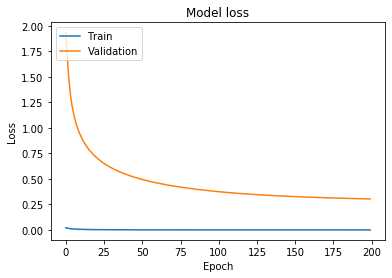

In [12]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
test_labels

In [ ]:
all_preds.argmax(dim=1)

In [ ]:
stacked = torch.stack((test_labels, all_preds.argmax(dim=1)),dim=1)
stacked.shape